# EDA

In [2]:
import os
import typing

import joblib
import pandas as pd
import numpy as np
import scipy
import sklearn.metrics
import seaborn as sns
import matplotlib.pyplot as plt
from pyts.image import RecurrencePlot, MarkovTransitionField, GramianAngularField
from statsmodels.datasets import co2
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import STL

In [2]:
import crunch

crunch = crunch.load_notebook()

loaded inline runner with module: <module '__main__'>

cli version: 6.6.1
available ram: 15.73 gb
available cpu: 16 core
----


In [3]:
# Load the data simply
X_train, y_train, X_test = crunch.load_data()

data\X_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_train.parquet (204327238 bytes)
data\X_train.parquet: already exists, file length match
data\X_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_test.reduced.parquet (2380918 bytes)
data\X_test.reduced.parquet: already exists, file length match
data\y_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_train.parquet (61003 bytes)
data\y_train.parquet: already exists, file length match
data\y_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_test.reduced.parquet (2655 bytes)
data\y_test.reduced.parquet: already exists, file length match


### Understanding `X_train`

The training data is structured as a pandas DataFrame with a MultiIndex:

**Index Levels:**
- `id`: Identifies the unique time series
- `time`: The timestep within each time series

**Columns:**
- `value`: The actual time series value at each timestep
- `period`: A binary indicator where `0` represents the **period before** the boundary point, and `1` represents the **period after** the boundary point

In [4]:
X_train

value  period
id    time                  
0     0    -0.005564       0
      1     0.003705       0
      2     0.013164       0
      3     0.007151       0
      4    -0.009979       0
...              ...     ...
10000 2134  0.001137       1
      2135  0.003526       1
      2136  0.000687       1
      2137  0.001640       1
      2138  0.001074       1

[23715734 rows x 2 columns]

In [ ]:
lengths = X_train.groupby('id').size()
print('时间序列长度描述性统计\n', lengths.describe())
print('时间序列长度分布')
plt.figure(figsize=(10, 6))
sns.histplot(lengths, bins=30, kde=True)
plt.xlabel('Length of Each Time Series')
plt.ylabel('Count')
plt.title('Distribution of Time Series Lengths per ID')
plt.grid(True)
plt.show()

In [ ]:
# 统计每个 id 在 period==0 和 period==1 下的长度
period_lengths = X_train.groupby(['id', 'period']).size().unstack(fill_value=0)
period0_lengths = period_lengths[0]
period1_lengths = period_lengths[1]

print('Period 0 长度分布描述性统计:\n', period0_lengths.describe())
print('Period 1 长度分布描述性统计:\n', period1_lengths.describe())

# 绘制两个子图
plt.figure(figsize=(14, 6))

# period==0
plt.subplot(1, 2, 1)
sns.histplot(period0_lengths, bins=30, kde=True, color='skyblue')
plt.xlabel('Length of Period 0')
plt.ylabel('Count')
plt.title('Distribution of Period 0 Lengths per ID')
plt.grid(True)

# period==1
plt.subplot(1, 2, 2)
sns.histplot(period1_lengths, bins=30, kde=True, color='salmon')
plt.xlabel('Length of Period 1')
plt.ylabel('Count')
plt.title('Distribution of Period 1 Lengths per ID')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# 统计每个 id 在 period==0 和 period==1 下的长度
period_lengths = X_train.groupby(['id', 'period']).size().unstack(fill_value=0)
period0_lengths = period_lengths[0]
period1_lengths = period_lengths[1]
total_lengths = period0_lengths + period1_lengths

# 计算比例
period1_ratio = period1_lengths / total_lengths

print('Period1 占比描述性统计:\n', period1_ratio.describe())

# 绘制比例分布图
plt.figure(figsize=(10, 6))
sns.histplot(period1_ratio, bins=30, kde=True, color='purple')
plt.xlabel('Proportion of Period 1 Length')
plt.ylabel('Count')
plt.title('Distribution of Period 1 Length Proportion per ID')
plt.grid(True)
plt.show()

In [ ]:
X_train.loc[0]

In [ ]:
def plot_moving_average_decomposition(X_train, y_train, id_=0, window=100):
    """
    使用滑动平均进行趋势与残差分解，并绘图（风格与 STL 相同）

    参数:
    - X_train: 包含 'value' 和 'period' 的 DataFrame，MultiIndex
    - y_train: 标签
    - id_: 指定的样本 id
    - window: 滑动平均窗口大小

    返回:
    - trend: 平滑后的趋势
    - residual: 残差
    """
    X_df = X_train.loc[id_]
    value_series = X_df['value'].reset_index(drop=True)
    period_series = X_df['period'].reset_index(drop=True).values

    trend = value_series.rolling(window=window, center=True, min_periods=1).mean()
    residual = value_series - trend

    # 绘图，3 行 1 列，与 STL 样式一致
    fig, axes = plt.subplots(3, 1, figsize=(6, 4), sharex=True)
    fig.suptitle(f'Moving Average Decomposition: ID {id_} Break={y_train.loc[id_]}', fontsize=16)

    transition_points = np.where(np.diff(period_series) != 0)[0]

    # 原始序列
    axes[0].plot(value_series, label='Observed', color='black')
    for point in transition_points:
        axes[0].axvline(point, color='red', linestyle='--', linewidth=1)
    axes[0].legend()

    # 趋势
    axes[1].plot(trend, label=f'Trend (MA window={window})', color='blue')
    for point in transition_points:
        axes[1].axvline(point, color='red', linestyle='--', linewidth=1)
    axes[1].legend()

    # 残差
    axes[2].plot(residual, label='Residual', color='orange')
    for point in transition_points:
        axes[2].axvline(point, color='red', linestyle='--', linewidth=1)
    axes[2].legend()

    plt.tight_layout()
    plt.show()

    return trend, residual

for i in range(15):
    trend, residual = plot_moving_average_decomposition(X_train, y_train, id_=i, window=200)

In [ ]:
def plot_stl_decomposition(X_train, y_train, id_=0, period=100, seasonal=15, robust=True):
    """
    对输入的 DataFrame (单一 id 的时间序列) 进行 STL 分解并绘图

    参数:
    - X_df: DataFrame，含有 'value' 列，index 是 time
    - period: 分解周期，建议设为与趋势相关的窗口大小
    - seasonal: 季节性平滑窗口（奇数）
    - robust: 是否使用鲁棒分解以减少异常值影响

    返回:
    - STL 分解结果对象
    """
    X_df = X_train.loc[id_]
    value_series = X_df['value'].reset_index(drop=True)
    period_series = X_df['period'].reset_index(drop=True).values

    stl = STL(value_series, period=period, seasonal=seasonal, robust=robust)
    result = stl.fit()

    fig = result.plot()
    fig.suptitle(f'STL: ID {id_} Break={y_train.loc[id_]}', fontsize=16)

    transition_points = np.where(np.diff(period_series) != 0)[0]

    for ax in fig.axes:
        for point in transition_points:
            ax.axvline(point, color='red', linestyle='--', linewidth=1)

    plt.tight_layout()
    plt.show()

    return result

for i in range(15):
    result = plot_stl_decomposition(X_train, y_train, id_=i, period=100, seasonal=15)

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Wed Feb 20 19:24:58 2019

@author: Vinícius Rezende Carvalho
"""
import numpy as np

def  VMD(f, alpha, tau, K, DC, init, tol):
    """
    u,u_hat,omega = VMD(f, alpha, tau, K, DC, init, tol)
    Variational mode decomposition
    Python implementation by Vinícius Rezende Carvalho - vrcarva@gmail.com
    code based on Dominique Zosso's MATLAB code, available at:
    https://www.mathworks.com/matlabcentral/fileexchange/44765-variational-mode-decomposition
    Original paper:
    Dragomiretskiy, K. and Zosso, D. (2014) ‘Variational Mode Decomposition’, 
    IEEE Transactions on Signal Processing, 62(3), pp. 531–544. doi: 10.1109/TSP.2013.2288675.
    
    
    Input and Parameters:
    ---------------------
    f       - the time domain signal (1D) to be decomposed
    alpha   - the balancing parameter of the data-fidelity constraint
    tau     - time-step of the dual ascent ( pick 0 for noise-slack )
    K       - the number of modes to be recovered
    DC      - true if the first mode is put and kept at DC (0-freq)
    init    - 0 = all omegas start at 0
                       1 = all omegas start uniformly distributed
                      2 = all omegas initialized randomly
    tol     - tolerance of convergence criterion; typically around 1e-6

    Output:
    -------
    u       - the collection of decomposed modes
    u_hat   - spectra of the modes
    omega   - estimated mode center-frequencies
    """
    
    if len(f)%2:
       f = f[:-1]

    # Period and sampling frequency of input signal
    fs = 1./len(f)
    
    ltemp = len(f)//2 
    fMirr =  np.append(np.flip(f[:ltemp],axis = 0),f)  
    fMirr = np.append(fMirr,np.flip(f[-ltemp:],axis = 0))

    # Time Domain 0 to T (of mirrored signal)
    T = len(fMirr)
    t = np.arange(1,T+1)/T  
    
    # Spectral Domain discretization
    freqs = t-0.5-(1/T)

    # Maximum number of iterations (if not converged yet, then it won't anyway)
    Niter = 500
    # For future generalizations: individual alpha for each mode
    Alpha = alpha*np.ones(K)
    
    # Construct and center f_hat
    f_hat = np.fft.fftshift((np.fft.fft(fMirr)))
    f_hat_plus = np.copy(f_hat) #copy f_hat
    f_hat_plus[:T//2] = 0

    # Initialization of omega_k
    omega_plus = np.zeros([Niter, K])


    if init == 1:
        for i in range(K):
            omega_plus[0,i] = (0.5/K)*(i)
    elif init == 2:
        omega_plus[0,:] = np.sort(np.exp(np.log(fs) + (np.log(0.5)-np.log(fs))*np.random.rand(1,K)))
    else:
        omega_plus[0,:] = 0
            
    # if DC mode imposed, set its omega to 0
    if DC:
        omega_plus[0,0] = 0
    
    # start with empty dual variables
    lambda_hat = np.zeros([Niter, len(freqs)], dtype = complex)
    
    # other inits
    uDiff = tol+np.spacing(1) # update step
    n = 0 # loop counter
    sum_uk = 0 # accumulator
    # matrix keeping track of every iterant // could be discarded for mem
    u_hat_plus = np.zeros([Niter, len(freqs), K],dtype=complex)    

    #*** Main loop for iterative updates***

    while ( uDiff > tol and  n < Niter-1 ): # not converged and below iterations limit
        # update first mode accumulator
        k = 0
        sum_uk = u_hat_plus[n,:,K-1] + sum_uk - u_hat_plus[n,:,0]
        
        # update spectrum of first mode through Wiener filter of residuals
        u_hat_plus[n+1,:,k] = (f_hat_plus - sum_uk - lambda_hat[n,:]/2)/(1.+Alpha[k]*(freqs - omega_plus[n,k])**2)
        
        # update first omega if not held at 0
        if not(DC):
            omega_plus[n+1,k] = np.dot(freqs[T//2:T],(abs(u_hat_plus[n+1, T//2:T, k])**2))/np.sum(abs(u_hat_plus[n+1,T//2:T,k])**2)

        # update of any other mode
        for k in np.arange(1,K):
            #accumulator
            sum_uk = u_hat_plus[n+1,:,k-1] + sum_uk - u_hat_plus[n,:,k]
            # mode spectrum
            u_hat_plus[n+1,:,k] = (f_hat_plus - sum_uk - lambda_hat[n,:]/2)/(1+Alpha[k]*(freqs - omega_plus[n,k])**2)
            # center frequencies
            omega_plus[n+1,k] = np.dot(freqs[T//2:T],(abs(u_hat_plus[n+1, T//2:T, k])**2))/np.sum(abs(u_hat_plus[n+1,T//2:T,k])**2)
            
        # Dual ascent
        lambda_hat[n+1,:] = lambda_hat[n,:] + tau*(np.sum(u_hat_plus[n+1,:,:],axis = 1) - f_hat_plus)
        
        # loop counter
        n = n+1
        
        # converged yet?
        uDiff = np.spacing(1)
        for i in range(K):
            uDiff = uDiff + (1/T)*np.dot((u_hat_plus[n,:,i]-u_hat_plus[n-1,:,i]),np.conj((u_hat_plus[n,:,i]-u_hat_plus[n-1,:,i])))

        uDiff = np.abs(uDiff)        
            
    #Postprocessing and cleanup
    
    #discard empty space if converged early
    Niter = np.min([Niter,n])
    omega = omega_plus[:Niter,:]
    
    idxs = np.flip(np.arange(1,T//2+1),axis = 0)
    # Signal reconstruction
    u_hat = np.zeros([T, K],dtype = complex)
    u_hat[T//2:T,:] = u_hat_plus[Niter-1,T//2:T,:]
    u_hat[idxs,:] = np.conj(u_hat_plus[Niter-1,T//2:T,:])
    u_hat[0,:] = np.conj(u_hat[-1,:])    
    
    u = np.zeros([K,len(t)])
    for k in range(K):
        u[k,:] = np.real(np.fft.ifft(np.fft.ifftshift(u_hat[:,k])))
        
    # remove mirror part
    u = u[:,T//4:3*T//4]

    # recompute spectrum
    u_hat = np.zeros([u.shape[1],K],dtype = complex)
    for k in range(K):
        u_hat[:,k]=np.fft.fftshift(np.fft.fft(u[k,:]))

    return u, u_hat, omega

In [ ]:
def plot_vmd_decomposition(X_train, y_train, id_=0, alpha=2000, tau=0, K=5, DC=0, init=1, tol=1e-7):
    """
    对输入的 DataFrame (单一 id 的时间序列) 进行 VMD 分解并绘图

    参数:
    - X_train: DataFrame，包含 'value' 和 'period'，multiindex
    - y_train: DataFrame，标签
    - id_: 指定分解的样本 id
    - alpha, tau, K, DC, init, tol: VMD 参数

    返回:
    - u: 分解后的模态
    - omega: 每个模态的中心频率
    """

    X_df = X_train.loc[id_]
    value_series = X_df['value'].reset_index(drop=True).values
    period_series = X_df['period'].reset_index(drop=True).values

    u, u_hat, omega = VMD(value_series, alpha=alpha, tau=tau, K=K, DC=DC, init=init, tol=tol)

    fig, axes = plt.subplots(K + 1, 1, figsize=(6, 1.5 * (K + 1)), sharex=True)
    fig.suptitle(f'VMD: ID {id_} Break={y_train.loc[id_]}', fontsize=16)

    transition_points = np.where(np.diff(period_series) != 0)[0]

    # 原始信号
    axes[0].plot(value_series, label='Original Signal', color='black')
    for point in transition_points:
        axes[0].axvline(point, color='red', linestyle='--', linewidth=1)
    axes[0].legend()

    # VMD 分解结果
    for k in range(K):
        axes[k + 1].plot(u[k, :], label=f'Mode {k + 1}')
        for point in transition_points:
            axes[k + 1].axvline(point, color='red', linestyle='--', linewidth=1)
        axes[k + 1].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    return u, omega

for i in range(15):
    u, omega = plot_vmd_decomposition(X_train, y_train, id_=i, K=3)

### Understanding `y_train`

This is a simple `pandas.Series` that tells if a dataset id has a structural breakpoint or not.

**Index:**
- `id`: the ID of the dataset

**Value:**
- `structural_breakpoint`: Boolean indicating whether a structural break occurred (`True`) or not (`False`)

In [ ]:
y_train

### Plot by image

In [ ]:
def TS2RP(data, args):
    dimension = args.get('dimension', 1)
    percentage = args.get('percentage', 1)
    rp = RecurrencePlot(dimension=dimension, percentage=percentage)
    data_reshaped = data.reshape(1, -1)
    rp_image = rp.fit_transform(data_reshaped)
    return rp_image

def TS2MTF(data, args):
    n_bins = args.get('n_bins', 10)
    image_size = args.get('image_size', 1.0)
    mtf = MarkovTransitionField(image_size=image_size, n_bins=n_bins)
    data_reshaped = data.reshape(1, -1)
    mtf_image = mtf.fit_transform(data_reshaped)
    return mtf_image

def TS2GAF(data, args):
    method = args.get('method', 'summation')
    gaf = GramianAngularField(method=method)
    data_reshaped = data.reshape(1, -1)
    gaf_image = gaf.fit_transform(data_reshaped)
    return gaf_image

In [ ]:
def plot_structure_break(img, df, break_flag, ax=None, title='Time Series Image'):
    # img shape: (1, H, W) 或 (H, W)
    if img.ndim == 3:
        image = img[0]
    else:
        image = img

    # 如果没有传入 ax，就新建一个图表
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    else:
        fig = ax.figure  # 获取子图所属的整个图对象

    cax = ax.imshow(image, cmap='viridis', aspect='auto')
    fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)

    # 找到 period 发生变化的边界索引
    period = df['period'].values
    boundary_indices = np.where(np.diff(period) != 0)[0] + 1

    # 绘制虚线
    for idx in boundary_indices:
        color = 'red' if break_flag else 'gray'
        label = 'Structure Break' if (break_flag and idx == boundary_indices[0]) else \
                'No Structure Break' if (not break_flag and idx == boundary_indices[0]) else None
        ax.axvline(x=idx, color=color, linestyle='--', linewidth=2, label=label)
        ax.axhline(y=idx, color=color, linestyle='--', linewidth=2)

    if boundary_indices.size > 0:
        ax.legend(loc='upper right')

    ax.set_title(title)
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Time Steps')

    return fig, ax

In [ ]:
def plot_time_series_with_breaks(df_idx):
    target_length = 3000
    df = X_train.loc[df_idx]
    flag = y_train.loc[df_idx]
    # print(df)
    data = df['value'].values
    print(f"📈 Raw Timeseries loaded, shape: {data.shape}")

    if len(data) < target_length:
        print(f"⏳ Padding with {target_length - len(data)} zeros to reach target length {target_length}")
        data = np.pad(data, (0, target_length - len(data)), mode='constant')

    rp_img = TS2RP(data, {'dimension': 1, 'percentage': 0.1})
    print(f"📊 Recurrence Plot image shape: {rp_img.shape}")
    mtf_img = TS2MTF(data, {'n_bins': 8})
    print(f"📊 Markov Transition Field image shape: {mtf_img.shape}")
    gaf_img = TS2GAF(data, {'method': 'summation'})
    print(f"📊 Gramian Angular Field image shape: {gaf_img.shape}")

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    plot_structure_break(rp_img, df, break_flag=flag, ax=axs[0], title='Recurrence Plot')
    plot_structure_break(mtf_img, df, break_flag=flag, ax=axs[1], title='Markov Transition Field')
    plot_structure_break(gaf_img, df, break_flag=flag, ax=axs[2], title='Gramian Angular Field')

    plt.tight_layout()
    plt.show()

In [ ]:
plot_time_series_with_breaks(0)

In [ ]:
plot_time_series_with_breaks(2)

In [ ]:
plot_time_series_with_breaks(6)

### Understanding `X_test`

The test data is provided as a **`list` of `pandas.DataFrame`s** with the same format as [`X_train`](#understanding-X_test).

It is structured as a list to encourage processing records one by one, which will be mandatory in the `infer()` function.

In [ ]:
X_test[0]

In [ ]:
lengths = [len(df) for df in X_test]
lengths = pd.Series(lengths)
print('时间序列长度描述性统计\n', lengths.describe())
print('时间序列长度分布')
plt.figure(figsize=(10, 6))
sns.histplot(lengths, bins=30, kde=True)
plt.xlabel('Length of Each Time Series')
plt.ylabel('Count')
plt.title('Distribution of Time Series Lengths per ID')
plt.grid(True)
plt.show()

## Strategy Implementation

There are multiple approaches you can take to detect structural breaks:

1. **Statistical Tests**: Compare distributions before and after the boundary point;
2. **Feature Engineering**: Extract features from both segments for comparison;
3. **Time Series Modeling**: Detect deviations from expected patterns;
4. **Machine Learning**: Train models to recognize break patterns from labeled examples.

The baseline implementation below uses a simple statistical approach: a t-test to compare the distributions before and after the boundary point.

### The `train()` Function

In this function, you build and train your model for making inferences on the test data. Your model must be stored in the `model_directory_path`.

The baseline implementation below doesn't require a pre-trained model, as it uses a statistical test that will be computed at inference time.

In [ ]:
def train(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    model_directory_path: str,
):
    # For our baseline t-test approach, we don't need to train a model
    # This is essentially an unsupervised approach calculated at inference time
    model = None

    # You could enhance this by training an actual model, for example:
    # 1. Extract features from before/after segments of each time series
    # 2. Train a classifier using these features and y_train labels
    # 3. Save the trained model

    joblib.dump(model, os.path.join(model_directory_path, 'model.joblib'))

### The `infer()` Function

In the inference function, your trained model (if any) is loaded and used to make predictions on test data.

**Important workflow:**
1. Load your model;
2. Use the `yield` statement to signal readiness to the runner;
3. Process each dataset one by one within the for loop;
4. For each dataset, use `yield prediction` to return your prediction.

**Note:** The datasets can only be iterated once!

In [ ]:
def infer(
    X_test: typing.Iterable[pd.DataFrame],
    model_directory_path: str,
):
    model = joblib.load(os.path.join(model_directory_path, 'model.joblib'))

    yield  # Mark as ready

    # X_test can only be iterated once.
    # Before getting the next dataset, you must predict the current one.
    for dataset in X_test:
        # Baseline approach: Compute t-test between values before and after boundary point
        # The negative p-value is used as our score - smaller p-values (larger negative numbers)
        # indicate more evidence against the null hypothesis that distributions are the same,
        # suggesting a structural break
        def t_test(u: pd.DataFrame):
            return -scipy.stats.ttest_ind(
                u["value"][u["period"] == 0],  # Values before boundary point
                u["value"][u["period"] == 1],  # Values after boundary point
            ).pvalue

        prediction = t_test(dataset)
        yield prediction  # Send the prediction for the current dataset

        # Note: This baseline approach uses a t-test to compare the distributions
        # before and after the boundary point. A smaller p-value (larger negative number)
        # suggests stronger evidence that the distributions are different,
        # indicating a potential structural break.

## Local testing

To make sure your `train()` and `infer()` function are working properly, you can call the `crunch.test()` function that will reproduce the cloud environment locally. <br />
Even if it is not perfect, it should give you a quick idea if your model is working properly.

In [ ]:
crunch.test(
    # Uncomment to disable the train
    # force_first_train=False,

    # Uncomment to disable the determinism check
    # no_determinism_check=True,
)

## Results

Once the local tester is done, you can preview the result stored in `data/prediction.parquet`.

In [ ]:
prediction = pd.read_parquet("data/prediction.parquet")
prediction

### Local scoring

You can call the function that the system uses to estimate your score locally.

In [ ]:
# Load the targets
target = pd.read_parquet("data/y_test.reduced.parquet")["structural_breakpoint"]

# Call the scoring function
sklearn.metrics.roc_auc_score(
    target,
    prediction,
)

oof preds

In [3]:
# hard_example_df = pd.read_csv('experiment/output/train_20250924_144307_auc_0_89453/oof_preds.csv')
hard_example_df = pd.read_csv('experiment/output/train_20250924_151259_auc_0_89975/oof_preds.csv')
hard_example_df.head()

,id,oof_preds,y
0,0,0.007081,0
1,1,0.037526,0
2,2,0.985966,1
3,3,0.011784,0
4,4,0.245485,0


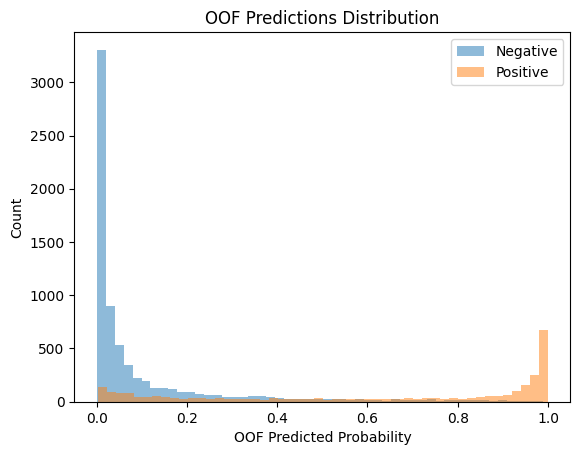

: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设 df 包含 'oof_preds' 和 'y'
# 正负样本分布对比
plt.hist(hard_example_df[hard_example_df.y==0].oof_preds, bins=50, alpha=0.5, label="Negative")
plt.hist(hard_example_df[hard_example_df.y==1].oof_preds, bins=50, alpha=0.5, label="Positive")
plt.xlabel("OOF Predicted Probability")
plt.ylabel("Count")
plt.legend()
plt.title("OOF Predictions Distribution")
plt.show()


In [10]:
# 难负样本: 真实标签为 0，但预测概率高（模型以为是正类）
hard_neg_idx = hard_example_df.loc[
    (hard_example_df['y'] == 0) & (hard_example_df['oof_preds'] > 0.5),
    'id'
].tolist()
print(len(hard_neg_idx))
# 难正样本: 真实标签为 1，但预测概率低（模型以为是负类）
hard_pos_idx = hard_example_df.loc[
    (hard_example_df['y'] == 1) & (hard_example_df['oof_preds'] < 0.2),
    'id'
].tolist()
print(len(hard_pos_idx))

321
469


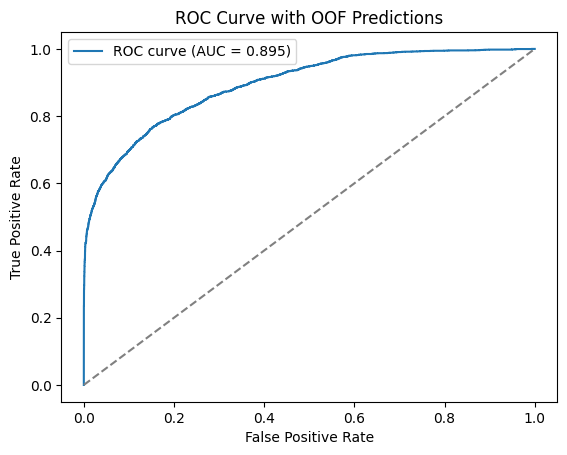

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(hard_example_df.y, hard_example_df.oof_preds)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with OOF Predictions")
plt.legend()
plt.show()